In [27]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import cv2
import numpy as np
import pandas as pd
import time
import pydicom
from scipy import interpolate

In [28]:
data_simul0 = np.loadtxt ("3d-dose-map.dat")

# Distribuição de dose Simulado

In [29]:
tam_x = 101
tam_y = 101
x = int(tam_y/2)+1
y = int(tam_x/2)+1
z = int(tam_x/2)+1

# x e y fixos e z variável
idx  = np.where(data_simul0[:,5] == x)                                                  
data = data_simul0[idx[0],:] 

idx2  = np.where(data[:,6] == y)                                                     
data2 = data[idx2[0],:] 

# z fixo x e y variáveis
idx3  = np.where(data_simul0[:,7] == z)
data3 = data_simul0[idx3[0],:]                            
norma2 = 100*(data2[:,3]/np.max(data2[:,3]))                                      

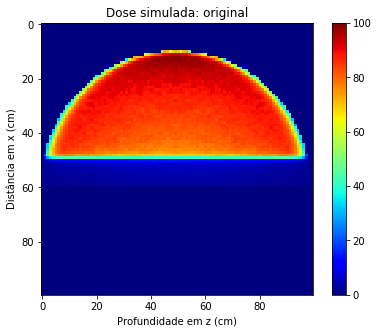

In [30]:
norma = 100*(data[:,3]/np.max(data[:,3])) 
v1 = np.reshape(data[:,1],(101,101)) 
v2 = np.reshape(data[:,2],(101,101))
v3 = np.reshape(norma,(101,101)) 
transposta = np.flip(v3, axis=1)

v_tot = v3 + transposta
normarot = 100*(v_tot[0:100,0:100]/np.max(v_tot[0:100,0:100]))
normarot = np.rot90(normarot,2)

plt.figure(figsize = (7,5))

plt.imshow(normarot,cmap = 'jet')
plt.colorbar();
plt.xlabel("Profundidade em z (cm)")
plt.ylabel("Distância em x (cm)")
plt.title('Dose simulada: original');

# Distribuição de dose Hospital

<Figure size 504x216 with 0 Axes>

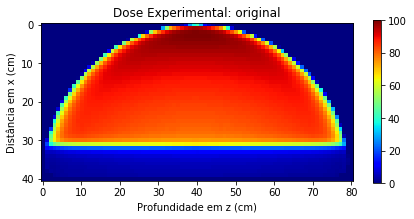

In [31]:
#Distribuição OP2 (sem filtro)

plt.figure(figsize = (7,3))
t1 = time.time()
data_orig4 = pydicom.dcmread("distribdose_OP2HEG.dcm") 
x = data_orig4.pixel_array
sob1 = 100*(x[13,0:42,0:82]/np.max(x[13,0:42,0:82]))

plt.figure(figsize = (7,3))

plt.imshow(sob1, cmap = 'jet')
plt.xlabel("Profundidade em z (cm)")
plt.ylabel("Distância em x (cm)")
plt.colorbar() 
plt.title('Dose Experimental: original');

# Recorte usando OpenCV </font>

In [32]:
def recorte(imagem, val_corte):
    imagem_new = imagem.copy()  
    thresh = cv2.threshold(imagem_new, val_corte, np.max(imagem), cv2.THRESH_BINARY)[1] 
    imagem_new[np.where((thresh)==0)] = 0  
    imagem_new = imagem_new[np.where([i.any()!=0 for i in imagem_new])[0]] 
    imagem_new = imagem_new[:,np.where([i.any()!=0 for i in np.transpose(imagem_new)])[0]]  
    return imagem_new

### Parâmetro de ajuste: Valor de pixel que queremos eliminar

In [33]:
val_corte=30

### Recortando a imagem experimental

Text(0.5, 1.0, 'Dose hospital - recortada')

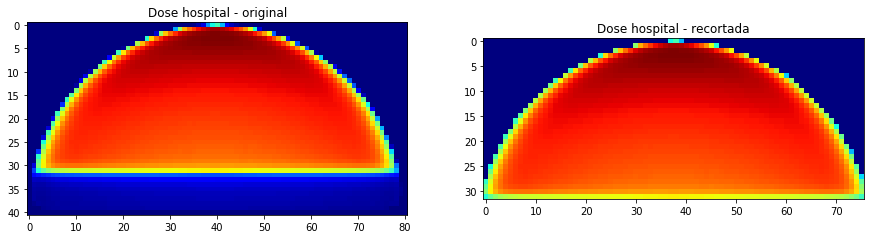

In [34]:
sob1_rec = recorte(sob1,val_corte)

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.imshow(sob1,cmap = 'jet')
plt.title('Dose hospital - original')

plt.subplot(1,2,2)
plt.imshow(sob1_rec,cmap = 'jet')
plt.title('Dose hospital - recortada')

### Recortando a imagem simulada

Text(0.5, 1.0, 'Dose simulada - recortada')

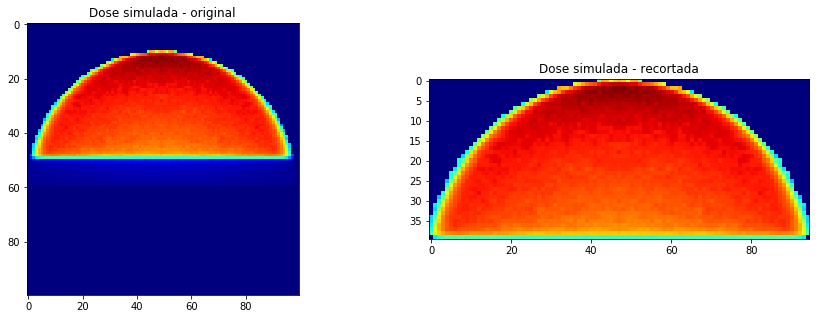

In [35]:
simulada = normarot
simulada_rec = recorte(simulada,val_corte)

plt.figure(figsize = (15,5))

plt.subplot(1,2,1)
plt.imshow(simulada,cmap = 'jet')
plt.title('Dose simulada - original')

plt.subplot(1,2,2)
plt.imshow(simulada_rec,cmap = 'jet')
plt.title('Dose simulada - recortada')

#  Ajustes interpolação </font>

In [36]:
def interpola(imagem_ajuste,imagem_base,val_corte):
    #imagem_ajuste é a imagem a ser interpolada e imagem_base é a imagem com as dimensões finais desejadas
    x = np.arange(0,np.shape(imagem_ajuste)[0],1)
    y = np.arange(0,np.shape(imagem_ajuste)[1],1)
    f = interpolate.interp2d (x,y,imagem_ajuste.flatten(),kind='linear')
    xnew = np.linspace(x[0],x[-1],np.shape(imagem_base)[0])
    ynew = np.linspace(y[0],y[-1],np.shape(imagem_base)[1])
    imagem_interp = np.transpose(f(xnew,ynew))
    return imagem_interp       

### Hipótese 1: Deixando as dimensões da imagem simulada iguais as da imagem experimental

In [37]:
imagem_ajuste1 = simulada_rec.copy()  #imagem a ser ajustada
imagem_base1 = sob1_rec.copy() # dimensões de base

imagem_interp1 = interpola(imagem_ajuste1,imagem_base1,val_corte)

% pixels com diferença > 1 56.41447368421053
Diferença Máxima: 72.15120006977418
(32, 76)
(40, 95)


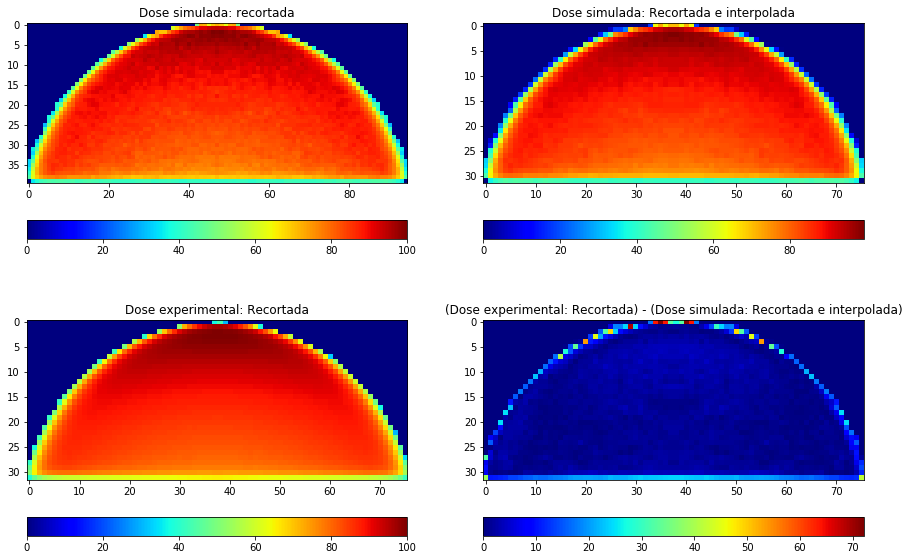

In [38]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.imshow(imagem_ajuste1,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose simulada: recortada')

plt.subplot(2,2,2)
plt.imshow(imagem_interp1,cmap='jet')
plt.colorbar( orientation="horizontal");
plt.title('Dose simulada: Recortada e interpolada')

plt.subplot(2,2,3)
plt.imshow(imagem_base1,cmap='jet')
plt.colorbar( orientation="horizontal");
plt.title('Dose experimental: Recortada')

plt.subplot(2,2,4)
plt.imshow(np.abs(imagem_base1 - imagem_interp1),cmap = 'jet')
plt.title('(Dose experimental: Recortada) - (Dose simulada: Recortada e interpolada)')
plt.colorbar( orientation = "horizontal");

print("% pixels com diferença > 1",100*np.shape(np.where(np.abs(imagem_base1-imagem_interp1)>1))[1]/(np.shape(imagem_base1)[0]*np.shape(imagem_base1)[1]))
print("Diferença Máxima:",np.max(np.abs(imagem_base1 - imagem_interp1)))

print (np.shape(imagem_base1)) #experimental
print (np.shape(imagem_ajuste1)) #simulada 

Text(0.5, 1.0, 'Distribuição de dose simulada')

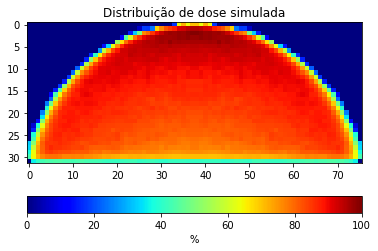

In [39]:
plt.imshow(imagem_interp1,cmap='jet')
plt.clim(0,100)
plt.colorbar(label="%", orientation="horizontal");
plt.title('Distribuição de dose simulada')

Text(0.5, 1.0, 'Distribuição de dose experimental')

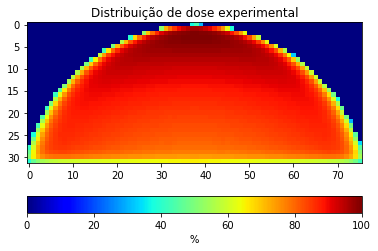

In [40]:
plt.imshow(imagem_base1,cmap='jet')
plt.colorbar( label="%", orientation="horizontal");
plt.title('Distribuição de dose experimental')

### Hipótese 2: Deixando as dimensões da imagem experimental iguais as da imagem simulada

In [41]:
imagem_base2 = simulada_rec.copy()  #imagem a ser ajustada
imagem_ajuste2 = sob1_rec.copy() # dimensões de base

imagem_interp2 = interpola(imagem_ajuste2,imagem_base2,val_corte)

% pixels com diferença > 1 55.921052631578945
Diferença máxima: 73.28304363867963


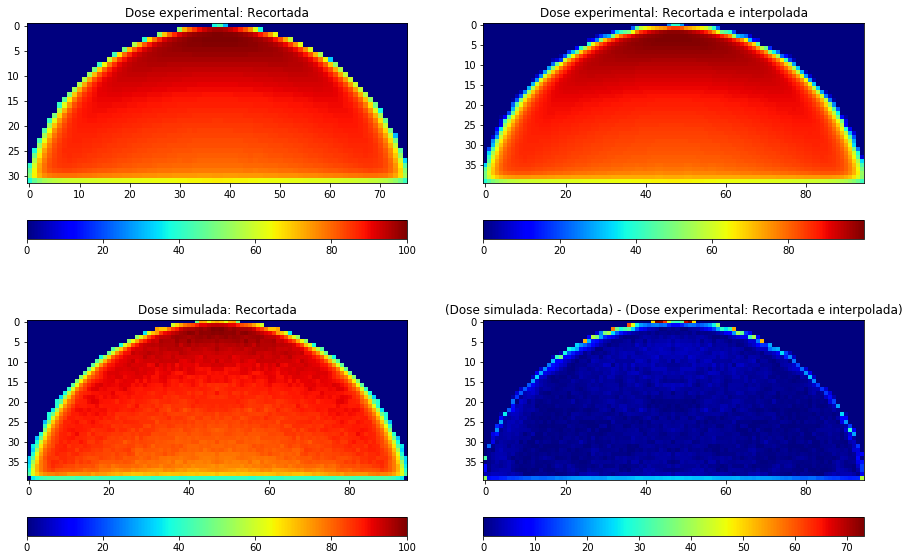

In [42]:
plt.figure(figsize = (15,10))

plt.subplot(2,2,1)
plt.imshow(imagem_ajuste2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose experimental: Recortada')

plt.subplot(2,2,2)
plt.imshow(imagem_interp2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose experimental: Recortada e interpolada')

plt.subplot(2,2,3)
plt.imshow(imagem_base2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose simulada: Recortada')

plt.subplot(2,2,4)
plt.imshow(np.abs(imagem_base2 - imagem_interp2),cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('(Dose simulada: Recortada) - (Dose experimental: Recortada e interpolada)')

print("% pixels com diferença > 1",100*np.shape(np.where(np.abs(imagem_base2-imagem_interp2)>1))[1]/(np.shape(imagem_base2)[0]*np.shape(imagem_base2)[1]))
print("Diferença máxima:",np.max(np.abs(imagem_base2 - imagem_interp2)))

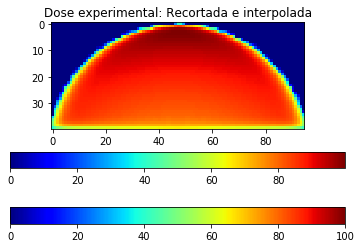

In [43]:
#Dose simulada recortada
plt.imshow(imagem_base2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose simulada: Recortada')
plt.savefig('Dose simulada', format='png')


#Dose experimental recortada e interpolada
plt.imshow(imagem_interp2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('Dose experimental: Recortada e interpolada')
plt.savefig('Dose experimental', format='png')

# Cortando dentro da área da imagem de base

#### Passo 1: Binarizacao

Text(0.5, 1.0, 'binarizada')

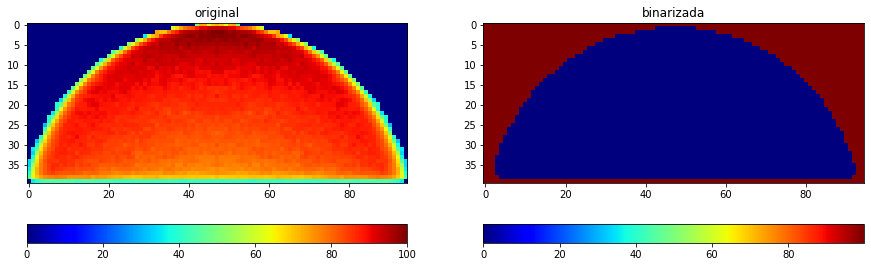

In [44]:
ret, thresh = cv2.threshold(imagem_interp2,70, np.max(imagem_interp2), cv2.THRESH_BINARY_INV)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(imagem_base2,cmap = 'jet')
plt.colorbar( orientation = "horizontal");
plt.title('original')
plt.subplot(1,2,2)
plt.imshow(thresh,cmap = 'jet')
plt.colorbar(orientation = "horizontal");
plt.title('binarizada')

#### Passo 2: Encontra as bordas

Text(0.5, 1.0, 'coordenadas das bordas')

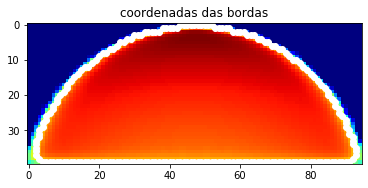

In [45]:
contours, hierarchy = cv2.findContours(thresh.astype(np.uint8),cv2.RETR_LIST, cv2.CHAIN_APPROX_NONE) 
contours = sorted(contours, key = cv2.contourArea,reverse=True)  
cont2plot = np.reshape(contours[1],(np.shape(contours[1])[0],np.shape(contours[1])[2])) 

plt.plot(cont2plot[:,0],cont2plot[:,1],'wo')
plt.imshow (imagem_interp2, cmap = 'jet')
plt.title('coordenadas das bordas')

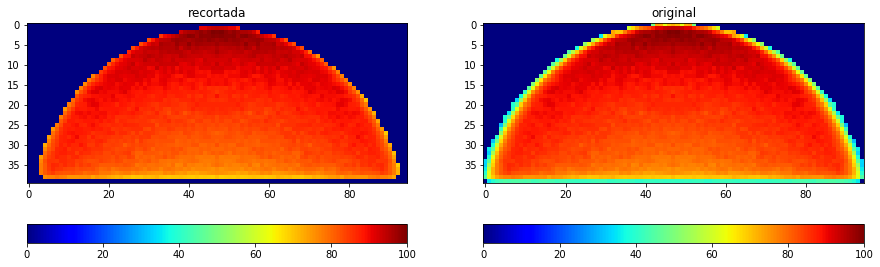

In [46]:
image = imagem_base2.copy()
img_base_recortada=cv2.fillPoly(image, contours, 0)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(img_base_recortada,cmap='jet')
plt.title('recortada')
plt.colorbar(orientation = "horizontal");
plt.subplot(1,2,2)
plt.title('original')

plt.imshow(imagem_base2,cmap='jet')
plt.colorbar(orientation = "horizontal");

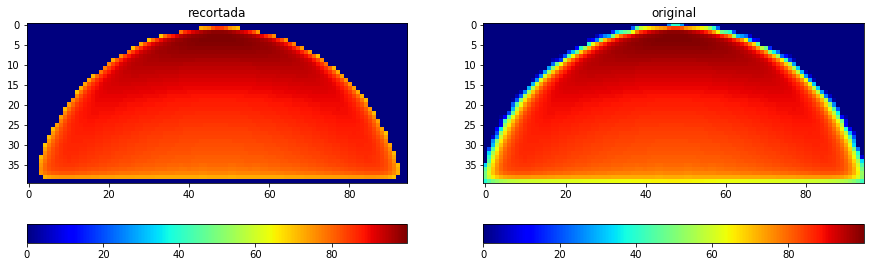

In [47]:
image = imagem_interp2.copy()
img_interp_recortada=cv2.fillPoly(image, contours, 0)

plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(img_interp_recortada,cmap='jet')
plt.title('recortada')
plt.colorbar(orientation = "horizontal");
plt.subplot(1,2,2)
plt.title('original')

plt.imshow(imagem_interp2,cmap='jet')
plt.colorbar(orientation = "horizontal");

# Resumindo: Imagens img_base_recortada e img_interp_recortada devem ser usadas para o cálculo do índice gama

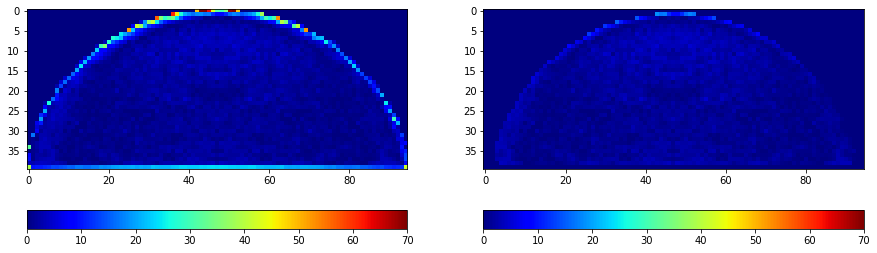

In [48]:
plt.figure(figsize = (15,5))
plt.subplot(1,2,1)
plt.imshow(np.abs(imagem_base2 - imagem_interp2),cmap = 'jet',vmin=0,vmax=70)
plt.colorbar(orientation = "horizontal");
plt.subplot(1,2,2)
plt.imshow(np.abs(img_base_recortada-img_interp_recortada),cmap = 'jet',vmin=0,vmax=70)
plt.colorbar(orientation = "horizontal");

In [49]:
idx = np.shape(img_base_recortada)[0] #dimensão da imagem
idy = np.shape(img_interp_recortada)[1]

dose = img_base_recortada
doseR = img_interp_recortada

x = np.arange(0,idx)
y = np.arange(0,idy)
xr = np.arange(0,idx)
yr = np.arange(0,idy)

dta = 0.3
tol = 3 

criterio = np.ones(np.shape(doseR),dtype = int) 
teste_dose = np.ones(np.shape(doseR),dtype = int)

In [50]:
for xx in range(0,len(x)):
    for yy in range(0,len(y)):
        gama1 = np.zeros(np.shape(doseR))
        for i in range(0,len(x)):
            for j in range(0,len(y)):
                r2 = (x[i]-xr[xx])**2 + (y[j]-yr[yy])**2 
                delta = np.abs(dose[i,j] - doseR[xx,yy])
                gama1[i,j] = np.sqrt((r2**2/dta**2) + (delta/tol**2))
                teste_dose[xx,yy] = np.min(gama1)
        if np.min(gama1)<= 1:
            criterio[xx,yy] = 0 
         
print('Resultado: 0 = Aceitável e 1 = Não aceitável')                
pd.DataFrame(criterio,index = xr,columns = yr)

Resultado: 0 = Aceitável e 1 = Não aceitável


,0,1,2,3,4,5,6,7,8,9,...,85,86,87,88,89,90,91,92,93,94
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [51]:
npt = 100* np.sum(np.sum(criterio))/(len(x)**2)
print('% de pontos não aceitáveis:',npt)

% de pontos não aceitáveis: 1.3125


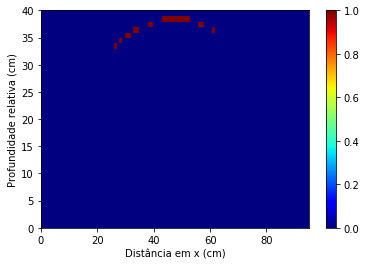

In [52]:
plt.pcolormesh(criterio[::-1,:], cmap='jet')
plt.colorbar()                                                                       
plt.xlabel("Distância em x (cm)")
plt.ylabel("Profundidade relativa (cm)")
plt.show()